<img src="files/night_sky_eye_small.jpg">
# Image_comparison Script

Jessica Metzger (UChicago) and Jim Annis (Fermilab) 2018


To run this notebook:
  * the geckodriver executable needs to be in the environmental variable $PATH
      **export PATH=$PATH:/data/des30.a/data/annis/dae-haven/py-lib/lib/python2.7/site-packages/geckodriver/
  * you'll need to run 
       ** conda activate des18a"
  * and set the python path:
       ** PYTHONPATH=$PYTHONPATH:/data/des30.a/data/annis/dae-haven/py-lib/lib/python;export PYTHONPATH;
       ** PYTHONPATH=$PYTHONPATH:/data/des30.a/data/annis/dae-haven/py-lib/lib/python2.7/site-packages;export PYTHONPATH;
       
 *(to run a notebook remotely, see 
 http://home.fnal.gov/~kadrlica/fnalstart.html
 
 ## How this should work
 
 * Given a search image:
 * Select from the 200mpc catalog the likely galaxies in the image as a list of ra,dec's
 * If in panstarrs area, run the current script for each ra, dec
     ** teach this code to know where the search image is
 * If we want to see DECam template images
 ** find the DECam images that overlap (from the diffimage pipeline or from Alex)
 *** teach the code to accept a list of template DECam images
 ** teach the code to look there for those images and deal gracefully with no matches
     *** where is there? ideally all the DECam images are on disk at Fermilab. There.


In [3]:
from astropy import wcs
from astropy.io import fits
import matplotlib.pyplot as plt
from matplotlib import colors
import numpy as np
import time,os
import glob
import fitsio

#import ps1
import support

In [16]:
# 
# given a ra,dec of a search image, 
# return the list of gals and thumbs
#
def get_list_of_gals_and_cutouts(ra,dec, path_to_cutouts="/data/des70.a/data/annis/s190510/", verbose=False) :
    file = glob.glob(path_to_cutouts + "matched*csv")
    dc_ra, dc_dec = np.genfromtxt(file[0],unpack=True,usecols=(0,1),delimiter=",", skip_header=1)
    thumb = np.genfromtxt(file[0],unpack=True,usecols=(3),delimiter=",",skip_header=1,dtype="str")
    
    distance = np.sqrt( ((ra-dc_ra)*np.cos(dc_dec*2*np.pi/360.))**2 + (dec-dc_dec)**2)
    #distance = support.gc_separation(ra, dec, dc_ra, dc_dec)
    ix = distance < 1.2
    gals_ra, gals_dec = dc_ra[ix], dc_dec[ix]
    for i in range(gals_ra.size):
        if verbose:
            print "{} {:10.5f} {:10.5f} \t {}".format(i, gals_ra[i], gals_dec[i], thumb[ix][i])
    return gals_ra, gals_dec, thumb[ix]
    
# 
# given a thumb name, return image
# return the list of gals and thumbs
#
def get_des_cutout_image(thumb_name, filter="g", path_to_cutouts="/data/des70.a/data/annis/s190510/") :
    fits = fitsio.FITS(path_to_cutouts+thumb_name+"_{}.fits".format(filter))
    img = fits[0].read()
    return img

In [94]:
%matplotlib inline
from astropy.coordinates import SkyCoord
from astropy.wcs import WCS
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.io import fits
import healpy as hp
import os
import numpy as np
import matplotlib.pyplot as plt
from math import fabs
import numpy as np
from astropy.wcs import WCS

def raw_cutout(infilename, ra,dec,stampSize, verbose=True): #Stampsize is half width
    
    ptsInside2Rp = []
    print("Opening file: " + infilename)
    hdulist = fits.open(infilename)
    
    found = False
    for ccd in range(1,63):
        if verbose: print ccd,
        header = fits.open(infilename)[ccd].header #pyfits.getheader(infilename, 0)
        #print header
        data = fits.open(infilename)[ccd].data
        try:
            ylen, xlen = data.shape[0], data.shape[1]
        except:
            if verbose: print "no data"
            continue
    
        #Find pixel at the candidate ra dec
        w = WCS(header=header) 
        px, py = w.all_world2pix(ra, dec, 1)
        objcoord = [px, py]
        if np.isnan(px) or np.isnan(py):
            if verbose: print "isnan"
            continue
        corners = w.calc_footprint()
        if (px < -1024 or px > 1024): continue
        if (py < -2048 or py > 2048): continue 
        print corners
        print ra,dec
        found = True
        if found: 
            print objcoord
            break
        
    if verbose: 
        if not found: 
        print "Not Found"
        return -1

    X = int(px)
    Y = int(py)
    
    #cutting image:
    
    sizy = np.min(np.array([stampSize, fabs(ylen-stampSize)]))
    sizx = np.min(np.array([stampSize, fabs(xlen-stampSize)]))  
    siz = int(np.min(np.array([sizy,sizx])))
    if verbose: print "cutout:",siz,px,py

    data = data[Y-siz:Y+siz+1,X-siz:X+siz+1]  

    return data

def cutout(infilename,ra,dec,stampSize): #Stampsize is half width
    
    ptsInside2Rp = []
    print("Opening file: " + infilename)
    hdulist = fits.open(infilename)
    header = fits.open(infilename)[1].header #pyfits.getheader(infilename, 0)
    data = fits.open(infilename)[1].data
    ylen, xlen = data.shape[0], data.shape[1]
    
    #Find pixel at the candidate ra dec
    w = WCS(header=header) 
    px, py = w.all_world2pix(ra, dec, 1)
    objcoord = [px, py]
   

    X = int(px)
    Y = int(py)
    
    #cutting image:
    
    sizy = np.min(np.array([stampSize, fabs(ylen-stampSize)]))
    sizx = np.min(np.array([stampSize, fabs(xlen-stampSize)]))  
    siz = int(np.min(np.array([sizy,sizx])))
    print "cutout:",siz,px,py

    data = data[Y-siz:Y+siz+1,X-siz:X+siz+1]  

    return data

def find_BLISS_image(cand_ra,cand_dec,stampSize):
    
    bands = ['g','r','i','z']
    cat_path = '/data/des81.a/data/luidhy/BLISS_allsky_try1/hpx/' 
    exp_path1 = '/data/des50.b/data/BLISS/'
    exp_path2 = '/data/des60.b/data/BLISS/'
    exp_path3 = '/data/des61.b/data/BLISS/'
    cat_nside = 32

    hpix = hp.ang2pix(cat_nside, cand_ra, cand_dec,lonlat=True)

    for band in bands:
        if hpix<10000:
            cat_file = cat_path+band+"/hpx_"+band+"_0"+str(hpix)+".fits"
        else:
            cat_file = cat_path+band+"/hpx_"+band+"_"+str(hpix)+".fits"
        if not os.path.isfile(cat_file):
            print "There is no source catalog in ", band
            exp_file = 0
            return ""
        else:
            h=fits.open(cat_file)[1].data
            print "Exposure available in ",band
            c1 = SkyCoord(cand_ra*u.deg, cand_dec*u.deg, frame='fk5')
            cat = SkyCoord(h['RA']*u.deg, h['DEC']*u.deg, frame='fk5')
            idx, d2d, d3d = c1.match_to_catalog_sky(cat)
            print "Closest object is at distance", d2d
            print "(RA,DEC)=",h['RA'][idx], h['DEC'][idx]
            print "Filter, mag, magerr", band, h['MAG_AUTO'][idx], h['MAGERR_AUTO'][idx]
            expnum = h['EXPNUM'][idx]
            ccdnum = h['CCDNUM'][idx]
            exp_fold = str(expnum)[:-2]+"00/"
            if (ccdnum<10): 
                ccdnum_str = "0"+str(ccdnum)
            else: 
                ccdnum_str = str(ccdnum)

            #Now open image

            exp_file1 = exp_path1+exp_fold+str(expnum)+"/D00"+str(expnum)+"_"+band+"_"+ccdnum_str+"_r1p1_immask.fits.fz"
            exp_file2 = exp_path2+exp_fold+str(expnum)+"/D00"+str(expnum)+"_"+band+"_"+ccdnum_str+"_r1p1_immask.fits.fz"
            exp_file3 = exp_path3+exp_fold+str(expnum)+"/D00"+str(expnum)+"_"+band+"_"+ccdnum_str+"_r1p1_immask.fits.fz"

            if os.path.isfile(exp_file1):
                exp_file = exp_file1
            elif os.path.isfile(exp_file2):
                exp_file = exp_file2
            elif os.path.isfile(exp_file3):
                exp_file = exp_file3
            else:
                print "Error: no exposure found in any path"
                exp_file = 0      

            #If image was found, make a cutout
            if (exp_file!=0):
                outfile = './cutouts/'+str(int(cand_ra))+str(int(cand_dec))+band+'.fits'
                img = cutout(exp_file,cand_ra,cand_dec,stampSize) #cand_ra,cand_dec
                img = np.rot90(img)
                img = np.fliplr(img)
      
            return img
    
def find_search_image(image_name, cand_ra,cand_dec,stampSize, dir="/data/des51.b/data/DTS/src/20190510/"):
    exp_file = dir+image_name
    img = raw_cutout(exp_file,cand_ra,cand_dec,stampSize) #cand_ra,cand_dec
    if img == -1: return -1
    img = np.rot90(img)
    img = np.fliplr(img)
      
    return img



IndentationError: expected an indented block (<ipython-input-94-6d16295a2c28>, line 52)

# Do the Eyeballing!

This is the action cell!

For a given image, get the 
image name, ra, dec

Change the triplets,
then run the cell, it will take time to do all of them

Exposure available in  g
Closest object is at distance [0d00m00.2486s]
(RA,DEC)= 87.42531749420819 -30.72266107286383
Filter, mag, magerr g 15.465662 0.001335578
Opening file: /data/des61.b/data/BLISS/718900/718991/D00718991_g_20_r1p1_immask.fits.fz
cutout: 74 1021.7229976894278 1282.3966812555855
Opening file: /data/des51.b/data/DTS/src/20190510/DECam_00856743.fits.fz
0 no data
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 [[ 87.37595322 -30.66721413]
 [ 87.72882642 -30.66736948]
 [ 87.72887201 -30.82535775]
 [ 87.3755312  -30.82526306]]
87.42528 -30.7226
[array(756.15524573), array(581.61260165)]
cutout: 92 756.1552457281355 581.6126016490954


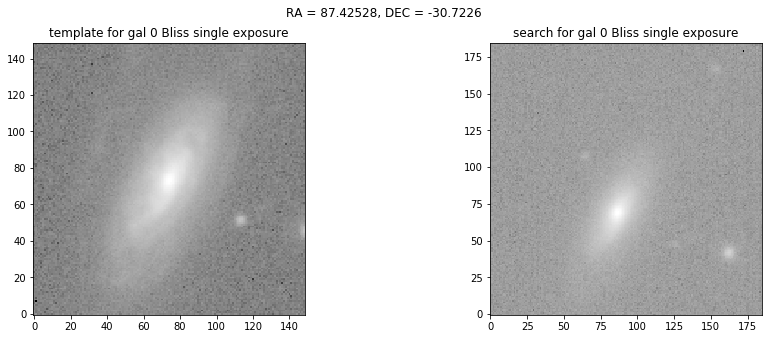

Opening file: /data/des51.b/data/DTS/src/20190510/DECam_00856743.fits.fz
0 no data
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 [[ 87.37595322 -30.66721413]
 [ 87.72882642 -30.66736948]
 [ 87.72887201 -30.82535775]
 [ 87.3755312  -30.82526306]]
87.42528 -30.7226
[array(756.15524573), array(581.61260165)]
cutout: 55 756.1552457281355 581.6126016490954


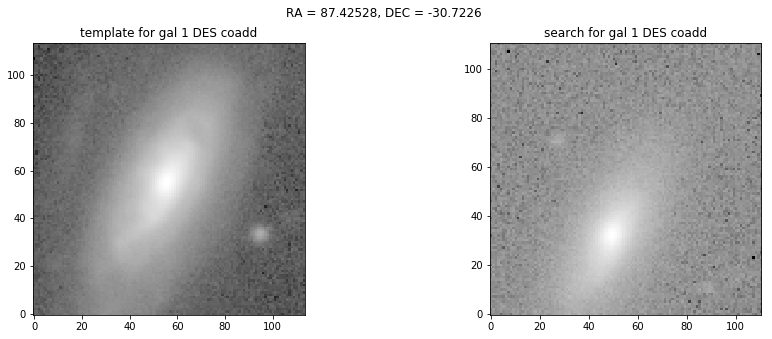

In [95]:
image_ra, image_dec = 87.42528, -30.7226
image_name = "DECam_00856743.fits.fz"
gra,gdec,thumbs = get_list_of_gals_and_cutouts(image_ra, image_dec)

#gra,gdec = np.ones(2)*image_ra, np.ones(2)*image_dec
#thumbs[0] = 'DESJ054942.1-304321.4'
#thumbs[1] = 'DESJ054942.1-304321.4'


pixscal=.27
for i in range(gra.size) :
    fig,axs=plt.subplots(1,2,figsize=(15,5))
    axs=axs.ravel()
    fig.suptitle('RA = '+str(round(gra[i],6))+', DEC = '+str(round(gdec[i],6)))
    
    match_cutout = 15
    go_big = 25
    if i == 1 :
        template = get_des_cutout_image(thumbs[i])
        label = "DES coadd"
        size = match_cutout/0.27
    
    if i == 0:
        template = find_BLISS_image(gra[i],gdec[i],size)
        label = "Bliss single exposure"
        size = go_big/0.27
    search = find_search_image(image_name,gra[i],gdec[i],size)
    #print search
    #if search == -1 or search == []: continue

    
    axs[0].imshow(np.log10(template-np.amin(template)+1),origin='lower',cmap='gray')
    axs[0].set_title('template for gal {} {}'.format(i, label))
    axs[1].imshow(np.log10(search-np.amin(search)+1),origin='lower',cmap='gray')
    axs[1].set_title('search for gal {} {}'.format(i,label))
    plt.show()

In [ ]:

# save new cutout to new folder
def get_search_image(RA,DEC,size,
                     fname="DECam_00850304.fits.fz",
                     path="/data/des51.b/data/DTS/src/20190509/"):
    # open new file
    hdul=fits.open(fname)
    header0=hdul[0].header
    
    for hdu in hdul[1:]:
        header=hdu.header
        img=np.array(hdu.data)
        
        # Parse the WCS keywords in the primary HDU
        w = wcs.WCS(header)
    
        wcoords=np.array([RA,DEC]).reshape((1,2))
        pixs=w.all_world2pix(wcoords,1)[0]
        
        if 0<=pixs[0]<img.shape[1] and 0<=pixs[1]<img.shape[0]:
            
            cutout=np.flip(np.flip(np.array(img[int(max(0,pixs[1]-size/2.)):int(min(img.shape[0],pixs[1]+size/2.)),
                            int(max(0,pixs[0]-size/2.)):int(min(img.shape[1],pixs[0]+size/2.))]),1).transpose(),1)
            
            #write file
            new_filename=path+'RA'+str(RA)+'_DEC'+str(DEC)+'.fits'
            try: fits.writeto(new_filename, cutout, header)
            except OSError:
                try:
                    os.remove(new_filename)
                    fits.writeto(new_filename, cutout, header)
                except OSError:
                    print('file saving error with '+str(RA)+', '+str(DEC))

            return cutout
        
    return 'coordinates not found'

In [ ]:
# example data

new_path='./new_images/'
RA_ls=[88.76485]
DEC_ls=[-33.14772]
    
pixscal=.27
for i in range(len(file_ls)):
    fig,axs=plt.subplots(1,2,figsize=(15,5))
    axs=axs.ravel()
    fig.suptitle('RA = '+str(round(RA_ls[i],6))+', DEC = '+str(round(DEC_ls[i],6)))
    
#     if not os.path.isfile(template_path+'RA'+str(round(RA_ls[i],5))+'_DEC'+str(round(DEC_ls[i],5))+'.fits'):
    #template_cutout=ps1.get_ps1_template_image(round(RA_ls[i],6),round(DEC_ls[i],6),300,browser,new_path)
    template_cutout=ps1.get_ps1_template_image(round(RA_ls[i],6),round(DEC_ls[i],6),300,browser,new_path)
    
#     if not os.path.isfile(new_path+'RA'+str(round(RA_ls[i],5))+'_DEC'+str(round(DEC_ls[i],5))+'.fits'):
    new_cutout=get_search_image(round(RA_ls[i],6),round(DEC_ls[i],6),300,original_path+file_ls[i],template_path)
#     new_cutout=np.array(new_cutout)
    
    axs[0].imshow(np.log10(template_cutout-np.amin(template_cutout)+1),origin='lower',cmap='gray')
    axs[0].set_title('template')
    axs[1].imshow(np.log10(new_cutout-np.amin(new_cutout)+1),origin='lower',cmap='gray')
    axs[1].set_title('new')
    plt.show()

In [ ]:
#Antonella's changes 04/29/2019 to make this work with BLISS images
#This part also finds if there are previous detections of the candidate!

In [ ]:
%matplotlib inline
from astropy.coordinates import SkyCoord
from astropy.wcs import WCS
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.io import fits
import healpy as hp
import os
import numpy as np
import matplotlib.pyplot as plt
from math import fabs
import numpy as np
from astropy.wcs import WCS


def cutout(infilename,ra,dec,stampSize, outfile): #Stampsize is half width
    
    ptsInside2Rp = []
    print("Opening file: " + infilename)
    hdulist = fits.open(infilename)
    header = fits.open(infilename)[1].header #pyfits.getheader(infilename, 0)
    data = fits.open(infilename)[1].data
    ylen, xlen = data.shape[0], data.shape[1]
    
    #Find pixel at the candidate ra dec
    w = WCS(header=header) 
    px, py = w.all_world2pix(ra, dec, 1)
    objcoord = [px, py]

    X = int(px)
    Y = int(py)
    
    #cutting image:
    
    sizy = np.min(np.array([stampSize, fabs(ylen-stampSize)]))
    sizx = np.min(np.array([stampSize, fabs(xlen-stampSize)]))  
    siz = int(np.min(np.array([sizy,sizx])))
    print siz,px,py

    data = data[Y-siz:Y+siz+1,X-siz:X+siz+1]  

    plt.imshow(data, origin='lower',cmap='gray')
    plt.title('RA='+str(ra)+', DEC='+str(dec))
    #Save outfile

def find_BLISS_image(cand_ra,cand_dec,stampSize):
    
    bands = ['g','r','i','z']
    cat_path = '/data/des81.a/data/luidhy/BLISS_allsky_try1/hpx/' 
    exp_path1 = '/data/des50.b/data/BLISS/'
    exp_path2 = '/data/des60.b/data/BLISS/'
    exp_path3 = '/data/des61.b/data/BLISS/'
    cat_nside = 32

    hpix = hp.ang2pix(cat_nside, cand_ra, cand_dec,lonlat=True)

    for band in bands:
        if hpix<10000:
            cat_file = cat_path+band+"/hpx_"+band+"_0"+str(hpix)+".fits"
        else:
            cat_file = cat_path+band+"/hpx_"+band+"_"+str(hpix)+".fits"
        if os.path.isfile(cat_file):
            h=fits.open(cat_file)[1].data
            print "Exposure available in ",band
            c1 = SkyCoord(cand_ra*u.deg, cand_dec*u.deg, frame='fk5')
            cat = SkyCoord(h['RA']*u.deg, h['DEC']*u.deg, frame='fk5')
            idx, d2d, d3d = c1.match_to_catalog_sky(cat)
            print "Closest object is at distance", d2d
            print "(RA,DEC)=",h['RA'][idx], h['DEC'][idx]
            print "Filter, mag, magerr", band, h['MAG_AUTO'][idx], h['MAGERR_AUTO'][idx]
            expnum = h['EXPNUM'][idx]
            ccdnum = h['CCDNUM'][idx]
            exp_fold = str(expnum)[:-2]+"00/"
            if (ccdnum<10): 
                ccdnum_str = "0"+str(ccdnum)
            else: 
                ccdnum_str = str(ccdnum)

            #Now open image

            exp_file1 = exp_path1+exp_fold+str(expnum)+"/D00"+str(expnum)+"_"+band+"_"+ccdnum_str+"_r1p1_immask.fits.fz"
            exp_file2 = exp_path2+exp_fold+str(expnum)+"/D00"+str(expnum)+"_"+band+"_"+ccdnum_str+"_r1p1_immask.fits.fz"
            exp_file3 = exp_path3+exp_fold+str(expnum)+"/D00"+str(expnum)+"_"+band+"_"+ccdnum_str+"_r1p1_immask.fits.fz"

            if os.path.isfile(exp_file1):
                exp_file = exp_file1
            elif os.path.isfile(exp_file2):
                exp_file = exp_file2
            elif os.path.isfile(exp_file3):
                exp_file = exp_file3
            else:
                print "Error: no exposure found in any path"
                exp_file = 0      

            #If image was found, make a cutout
            if (exp_file!=0):
                outfile = './cutouts/'+str(int(cand_ra))+str(int(cand_dec))+band+'.fits'
                cutout(exp_file,cand_ra,cand_dec,stampSize,outfile) #cand_ra,cand_dec

        else:
            print "There is no source catalog in ", band
            exp_file = 0

In [ ]:
# This is where the cutout is given:

# Your inputs here
cand_ra = 88.764850  #J2000 deg, [0,360]
cand_dec =33.147720 #J2000 deg
#cand_ra = 340.394736 #340.3957286881805 # #J2000 deg, [0,360]
#cand_dec = 7.6819850 #7.681786834893399 #J2000 deg
#cand_ra = 255.58   #J2000 deg, [0,360]
#cand_dec = -12.48562   #J2000 deg
stampSize = 20

find_BLISS_image(cand_ra,cand_dec,stampSize)

In [ ]:
# This is where the cutout is given:

# Your inputs here
cand_ra = 88.764850  #J2000 deg, [0,360]
cand_dec =33.147720 #J2000 deg
#cand_ra = 340.394736 #340.3957286881805 # #J2000 deg, [0,360]
#cand_dec = 7.6819850 #7.681786834893399 #J2000 deg
#cand_ra = 255.58   #J2000 deg, [0,360]
#cand_dec = -12.48562   #J2000 deg
stampSize = 20

find_BLISS_image(cand_ra,cand_dec,stampSize)

In [ ]:
#AP: Not sure what this does, it was the third entry

# open headless browser
# laptop
# driver=webdriver.Firefox(executable_path='/Users/jmetzger/anaconda3/bin/geckodriver')
# des machines
driver=webdriver.Firefox(executable_path='/data/des30.a/data/annis/dae-haven/py-lib/lib/python2.7/site-packages/geckodriver/geckodriver')
browser=Browser(headless=True)
# the geckodriver executable needs to be in the environmental variable $PATH
# export PATH=$PATH:/data/des30.a/data/annis/dae-haven/py-lib/lib/python2.7/site-packages/geckodriver/

